In [ ]:
#OM

#### Importing tfds library

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
tfds.load('eurosat')

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteMU9TF9/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


{'train': <PrefetchDataset shapes: {filename: (), image: (64, 64, 3), label: ()}, types: {filename: tf.string, image: tf.uint8, label: tf.int64}>}

In [ ]:
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir='/content/drive/My Drive/Colab Notebooks/Florence/sample_data/')

In [ ]:
print(ds)

<PrefetchDataset shapes: {filename: (), image: (64, 64, 3), label: ()}, types: {filename: tf.string, image: tf.uint8, label: tf.int64}>


In [ ]:
dataset = ds.from_tensors([1,2,3])

In [ ]:
DATA_DIR='/content/drive/My Drive/Colab Notebooks/Florence/sample_data1/'

In [ ]:
ds_train, ds_valid = tfds.load('eurosat/rgb',
                               split=['train[:70%]', 'train[70%:]'],
                               data_dir=DATA_DIR,
                               as_supervised=True)

#### Eurosat example images

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


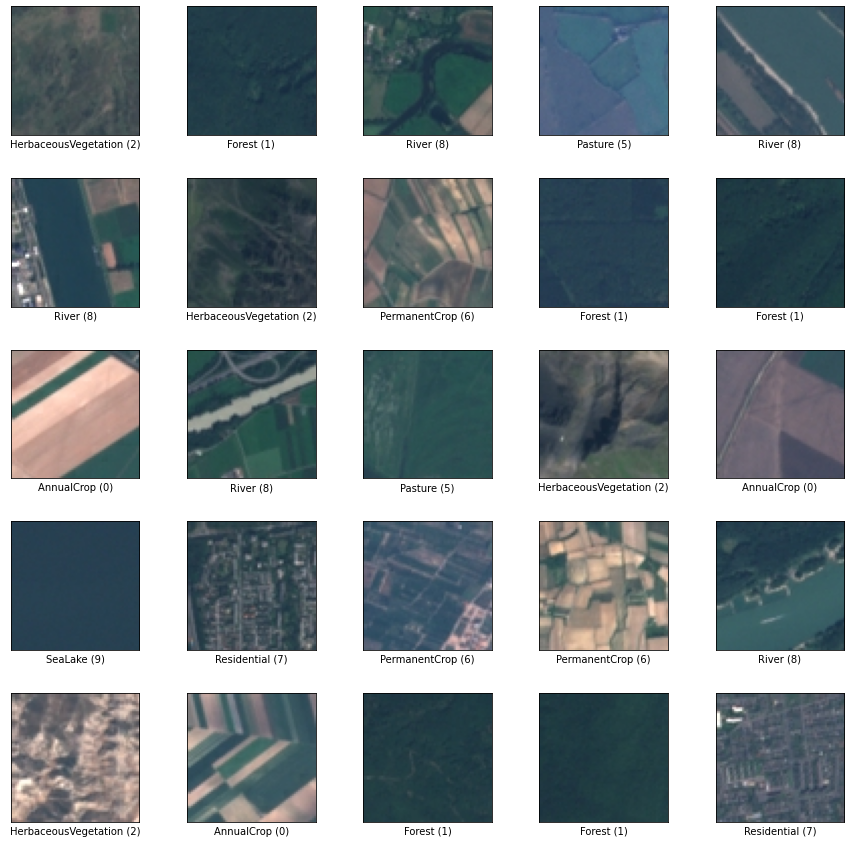

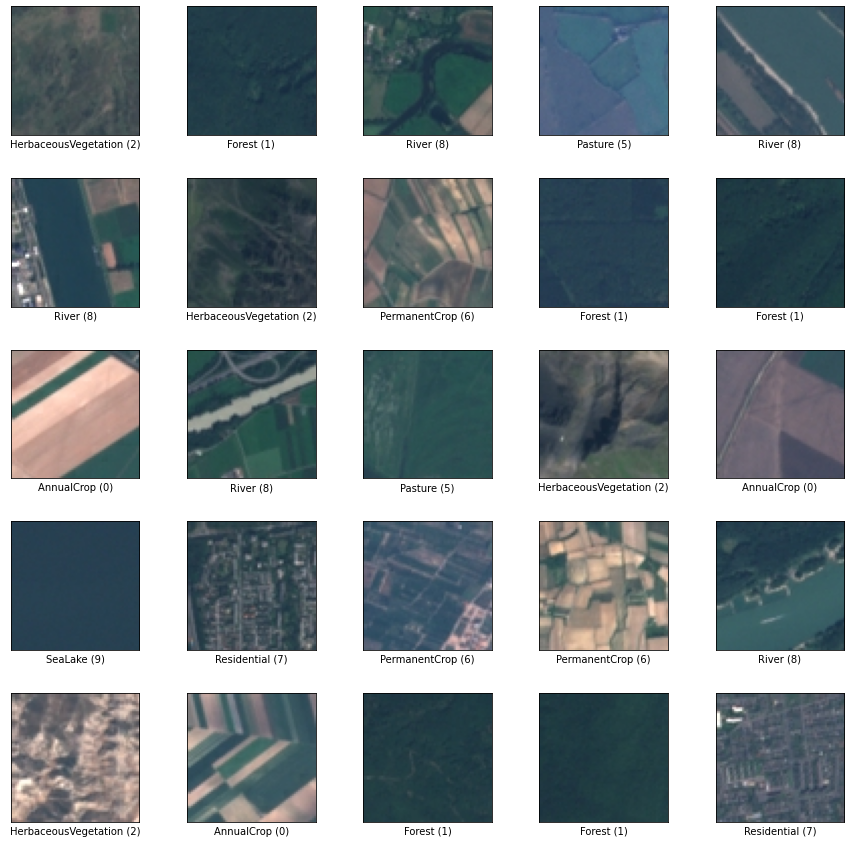

In [ ]:
tfds.show_examples(ds_info,ds,rows=5,cols=5)

### **Constructing a PIPELINE**

In [ ]:
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER = int(ds_info.splits['train'].num_examples * 0.7)

ds_train, ds_valid = tfds.load('eurosat/rgb',
                               split=['train[:70%]', 'train[70%:]'],
                               data_dir=DATA_DIR,
                               as_supervised=True)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

ds_train = (ds_train
            .map(preprocess, AUTO)
            .cache()
            .shuffle(SHUFFLE_BUFFER)
            .repeat()
            # Augmentations go here .map(augment, AUTO)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(AUTO))

ds_valid = (ds_valid
            .map(preprocess, AUTO)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

### **Define Model**

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

NUM_CLASSES = ds_info.features['label'].num_classes

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='elu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='elu'),
    layers.Conv2D(32, 3, padding='same', activation='elu'),
     layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='elu'),
    layers.Conv2D(64, 3, padding='same', activation='elu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    # layers.Dense(2048, activation='elu'),
    # layers.Dense(1024, activation='elu'),
    # layers.Dense(512, activation='elu'),
    # layers.Dropout(0.5),
    #layers.Dense(256, activation='elu'),
    
    #layers.Dense(128, activation='elu'),
    #layers.Dropout(0.5),
    layers.Dense(64, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
model.compile(
    optimizer='adagrad',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

#### Training the model

In [ ]:
EPOCHS = 150
STEPS_PER_EPOCH = int(ds_info.splits['train'].num_examples * 0.7) // BATCH_SIZE

early_stopping = tf.keras.callbacks.EarlyStopping(patience=7, min_delta=0.0001, restore_best_weights=True)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping],
)

Epoch 1/150
1181/1181 [==============================] - 7s 6ms/step - loss: 1.5400 - sparse_categorical_accuracy: 0.4641 - val_loss: 0.9004 - val_sparse_categorical_accuracy: 0.6907
Epoch 2/150
1181/1181 [==============================] - 6s 5ms/step - loss: 1.1810 - sparse_categorical_accuracy: 0.5932 - val_loss: 0.7608 - val_sparse_categorical_accuracy: 0.7417
Epoch 3/150
1181/1181 [==============================] - 7s 6ms/step - loss: 1.0617 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.7579
Epoch 4/150
1181/1181 [==============================] - 7s 6ms/step - loss: 1.0035 - sparse_categorical_accuracy: 0.6575 - val_loss: 0.6531 - val_sparse_categorical_accuracy: 0.7749
Epoch 5/150
1181/1181 [==============================] - 7s 6ms/step - loss: 0.9419 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.6131 - val_sparse_categorical_accuracy: 0.7881
Epoch 6/150
1181/1181 [==============================] - 7s 6ms/step - loss: 0.9074 -

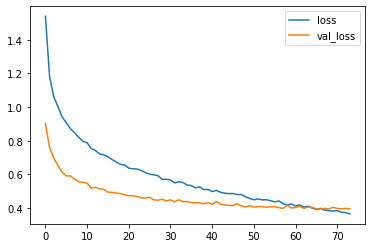

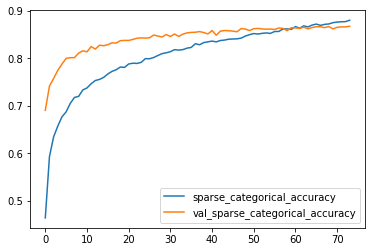

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

### **Saving the model**

In [ ]:
model.save("/content/drive/Shared drives/Coastal_Image_Analysis/Data/eurosat_model_modi.h5")

In [1]:
import numpy as np


#### Importing images

In [ ]:
from glob import glob
from numpy import asarray
from PIL import Image
from IPython.display import clear_output
import csv
root_dir = '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs'
filelist_csv = open('/content/drive/Shared drives/Coastal_Image_Analysis/flielist.csv',mode='w')
writer=csv.writer(filelist_csv)
img_list = []
file_list = glob(root_dir+'/*.jpg')
tot_images = len(file_list)
for n,img in enumerate(file_list):
  clear_output(wait=True)
  img_data = Image.open(img)
  img_data = img_data.resize((64,64))
  img_data = asarray(img_data)
  img_list.append(img_data)
  writer.writerow([img])
  p = (n/tot_images)*100
  print("Percentage Completed: {:0.2f}%".format(p))


In [ ]:
#from numpy import load
from numpy import savez_compressed
savez_compressed('/content/drive/Shared drives/Coastal_Image_Analysis/Data/64resizednewimagearray.npz',img_list)

In [2]:
data = np.load('/content/drive/Shared drives/Coastal_Image_Analysis/Data/64resizednewimagearray.npz')

In [3]:
data.files

['arr_0']

In [4]:
data = data['arr_0']

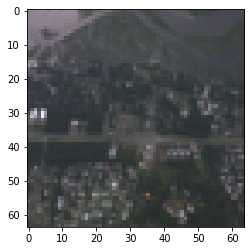

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data[3200])


In [ ]:
data.shape

(3642, 64, 64, 3)

In [5]:
#Importing libraries
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"]=False
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import glob
import cv2
from sklearn.metrics import silhouette_score
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from google.colab.patches import cv2_imshow
import os
import random
import shutil

Loading the model and popping the last layers out

In [6]:
new_model = tf.keras.models.load_model('/content/drive/Shared drives/Coastal_Image_Analysis/Data/eurosat_model.h5')


In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

In [7]:
new_model.pop()
new_model.pop()
new_model.pop()
new_model.pop()
new_model.pop()
new_model.pop()

####Modified model

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

### **Predicting our data based on our saved and loaded model**

In [8]:
predictions = new_model.predict(data.reshape(-1, 64, 64, 3))


In [9]:
pred_images = predictions.reshape(data.shape[0], -1)

In [10]:
pred_images.shape

(3642, 4096)

In [10]:
#Importing libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import glob
import cv2
from sklearn.metrics import silhouette_score
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from google.colab.patches import cv2_imshow
import os
import random
import shutil

Silhoutte Score for number optimal K

In [ ]:
sil = []
kl = []
kmax = 20
for k in range(5, kmax+1):
    kmeans2 = KMeans(n_clusters = k).fit(pred_images)
    labels = kmeans2.labels_
    sil.append(silhouette_score(pred_images, labels, metric =   'manhattan'))
    kl.append(k)

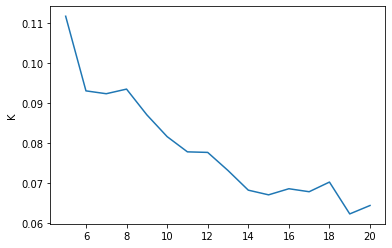

In [ ]:
plt.plot(kl, sil)
plt.ylabel('Silhoutte Score')
plt.ylabel('K')
plt.show()

Elbow method for optimal K

In [ ]:
#Calculating sum of squared distances for each cluster number
Sum_of_squared_distances = []
K = range(3,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pred_images)
    Sum_of_squared_distances.append(km.inertia_)
    #Sum_of_squared_distances.append(math.log(km.inertia_))

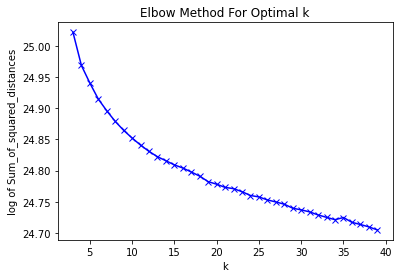

In [ ]:
#Plotting
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('log of Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1d21e3940>,
                 k=None, metric=None, model=None, timings=True)

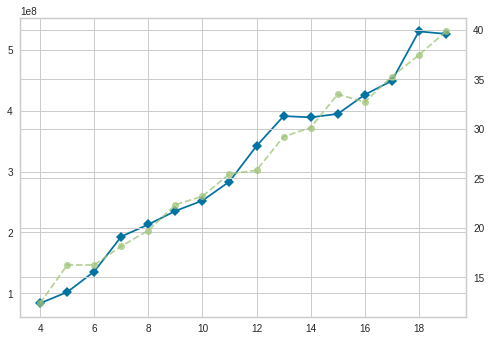

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20))

visualizer.fit(pred_images)        # Fit the data to the visualizer


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd22469e710>,
                 k=None, metric=None, model=None, timings=True)

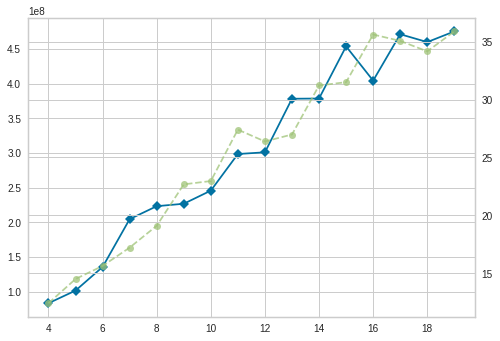

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20),force_model=True)

visualizer.fit(pred_images)        # Fit the data to the visualizer


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f779d5e1898>,
                 k=None, metric=None, model=None, timings=False)

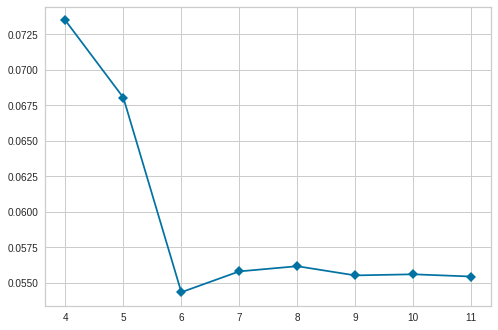

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='silhouette', timings=False
)

visualizer.fit(pred_images)        # Fit the data to the visualizer

#### Performing K-means clustering

In [11]:
k = 9
kmodel = KMeans(n_clusters = k, n_jobs=-1, random_state=728)
kmodel.fit(pred_images)
kpredictions = kmodel.predict(pred_images)
#shutil.rmtree('output')

In [ ]:
# For the generated clusters, Creating Individual folders on Drive
for i in range(k):
    os.makedirs("/content/drive/My Drive/Colab Notebooks/Florence/Eurosat_clusters/" + str(i))
# Using shutil module to copy the images to respective clusters
for i in range(len(orig_img_list)):
    shutil.copy2(orig_img_list[i], "/content/drive/My Drive/Colab Notebooks/Florence/Eurosat_clusters/"+str(kpredictions[i]))

In [12]:
k_means_labels = kmodel.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1 2 3 4 5 6 7 8]


In [13]:
G = len(np.unique(k_means_labels)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


#### Displaying Images from different clusters

Cluster 0


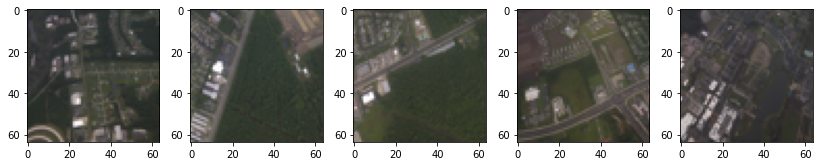

Cluster 1


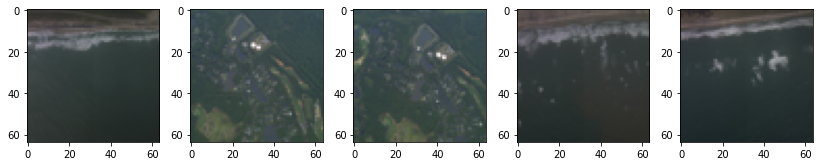

Cluster 2


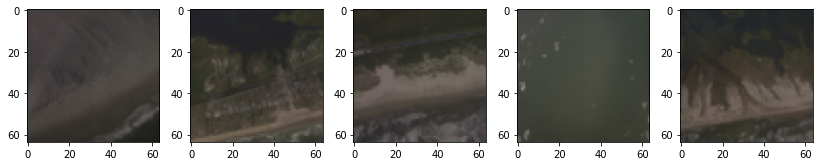

Cluster 3


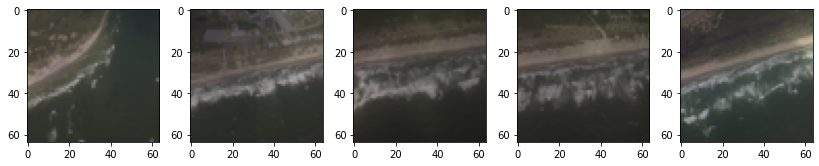

Cluster 4


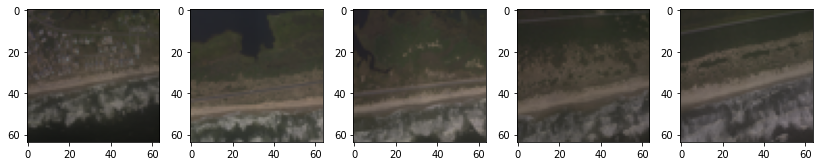

Cluster 5


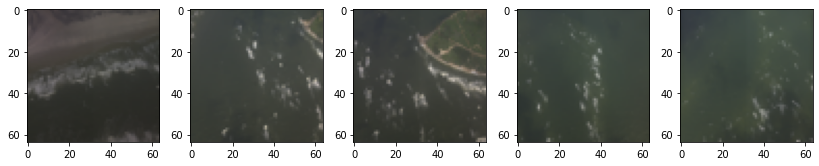

Cluster 6


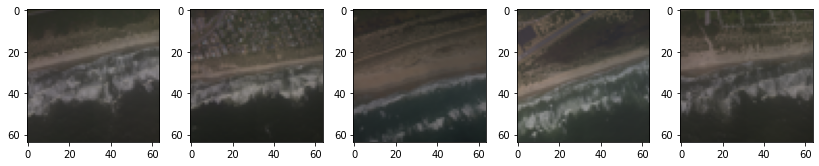

Cluster 7


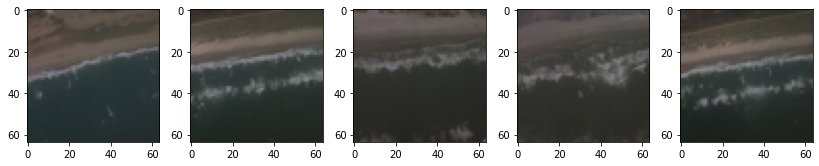

Cluster 8


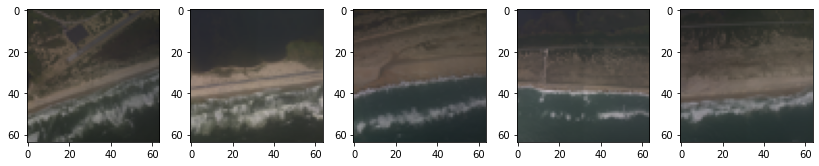

In [16]:
#Visualisation for clusters = clust
clust = 9
num = 5 #num of data to visualize from the cluster
for j in range(0,clust):
  plt.figure(figsize=(20,20))
  #plt.clf()
  print('Cluster '+str(j))
  for i in range(1,num+1):
    plt.subplot(7, 7, i) #(Number of rows, Number of column per row, item number)
    plt.imshow(data[cluster_index[j][i]].reshape(64,64,3))     
  plt.show()

#### Gradmap Function

In [ ]:
pip install cv2_plt_imshow

     |████████████████████████████████| 49.4MB 81kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
from google.colab.patches import cv2_imshow
#import cv2_plt_imshow 
#cv2_plt_imshow import cv2_plt_imshow,plt_format
clust=8
n=3
def gradmap():
  for num,j in enumerate(['Zero','One','Two','Three','Four','Five','Six','Seven','Eight']):
    #p=path+j
    #files=os.listdir(p)
    print("Cluster "+j)
    for i in range(n):
      d=random.choice(range(len(cluster_index[num])))
      #new_img = image.load_img(p+"/"+d, target_size=(224, 224))
      new_img_tensor = data[cluster_index[num][d]]
      new_img_tensor_x1 = np.expand_dims(new_img_tensor, axis=0)
      new_img_tensor_x1.shape
      with tf.GradientTape() as tape:
        layers = [layer.name for layer in new_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
        last_conv_layer = new_model.get_layer(layers[-1])
        iterate = tf.keras.models.Model([new_model.inputs], [new_model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(new_img_tensor_x1)
      #class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(model_out,last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
      heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)
      heatmap = heatmap.reshape((16, 16))
      #plt.matshow(heatmap)
      #plt.show()
      new_img_org = data[cluster_index[num][d]]
      INTENSITY = 0.5
      heatmap = cv2.resize(heatmap, (new_img_org.shape[1], new_img_org.shape[0]))
      heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
      new_img = heatmap * INTENSITY + new_img_org

      #im=cv2_imshow(new_img)
      
      #scale_percent = 40 # percent of original size
      #width = int(new_img.shape[1] * scale_percent / 100) 
      #height = int(new_img.shape[0] * scale_percent / 100) 
      #dim = (width, height) 

      # resize image
      #resized = cv2.resize(new_img, dim, interpolation = cv2.INTER_AREA) 
      #print(new_img.shape)
      #img_float32 = np.float32(new_img)
      #plt.figure(figsize=(50,50))
      
      plt.imshow(data[cluster_index[num][d]])
      plt.show()
      cv2_imshow(new_img.astype(np.uint8))
      plt.show()
      #cv2.waitKey()
    
 
    

#### Displaying gradmap image with original image

Cluster Zero


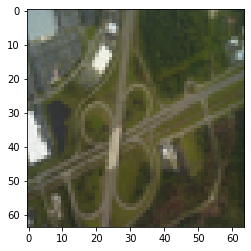

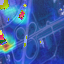

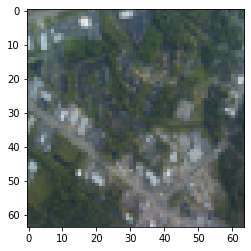

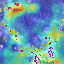

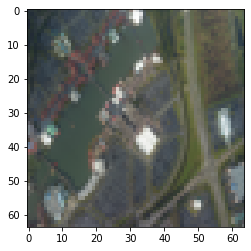

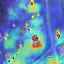

Cluster One


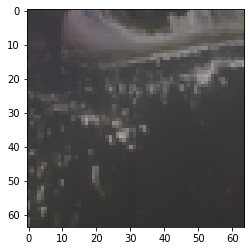

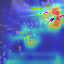

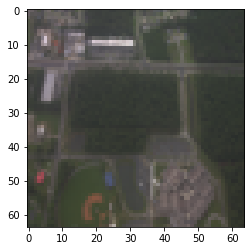

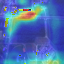

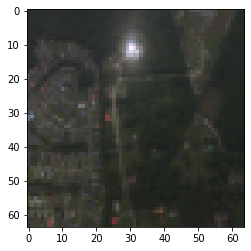

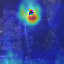

Cluster Two


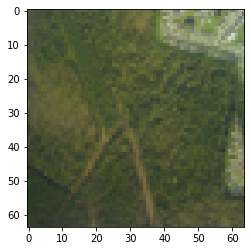

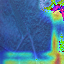

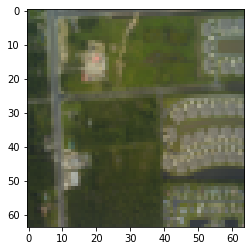

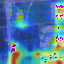

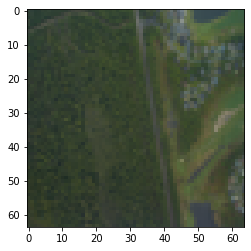

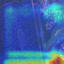

Cluster Three


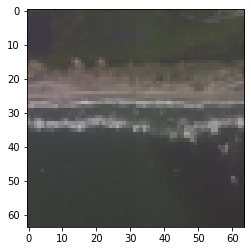

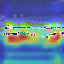

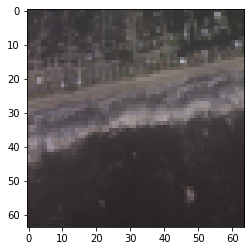

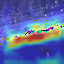

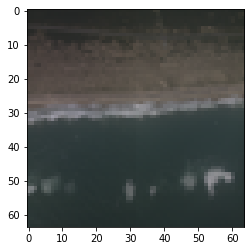

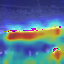

Cluster Four


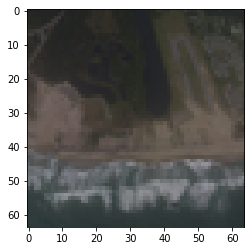

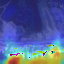

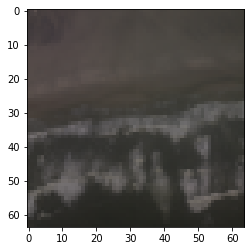

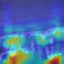

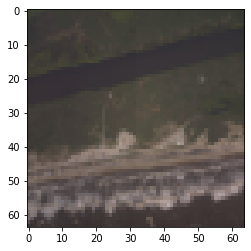

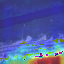

Cluster Five


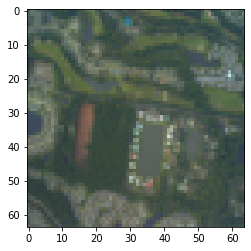

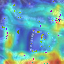

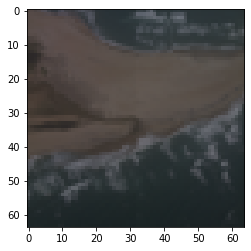

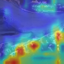

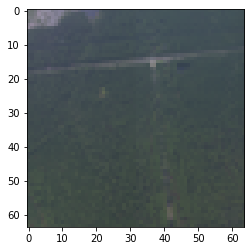

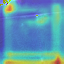

Cluster Six


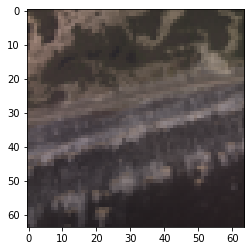

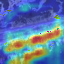

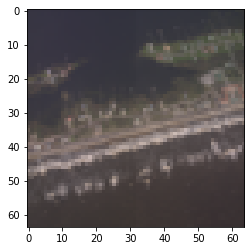

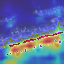

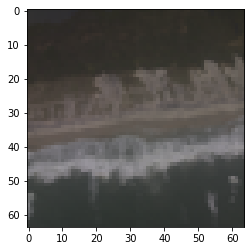

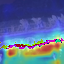

Cluster Seven


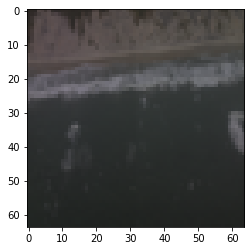

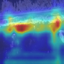

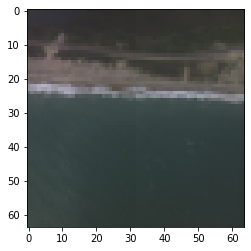

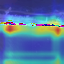

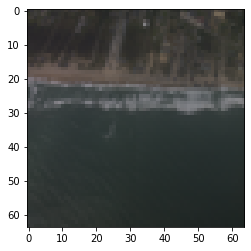

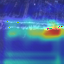

Cluster Eight


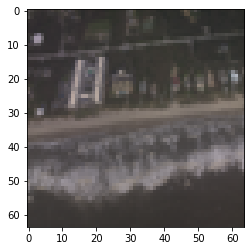

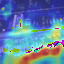

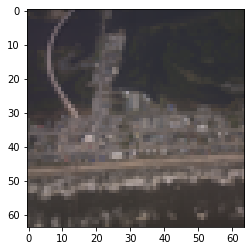

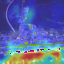

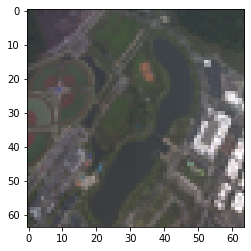

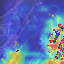

In [ ]:
gradmap()

### TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
data.shape

(3642, 64, 64, 3)

In [ ]:
data2=np.array(np.float32(pred_images)/255)

In [ ]:
tsne = TSNE().fit_transform(data2)


In [ ]:
tsne3d=TSNE(n_components=3).fit_transform(data2)

In [ ]:
tsne_components = pd.DataFrame(tsne,columns=['comp1','comp2'])

In [ ]:
tsne_components3d = pd.DataFrame(tsne3d,columns=['comp1','comp2','comp3'])

In [ ]:
tsne_components['cluster']=k_means_labels

In [ ]:
tsne_components3d['cluster']=k_means_labels

In [ ]:
tsne_components3d.head()

comp1      comp2      comp3  cluster
0  22.542315 -22.639172   4.719445        1
1   8.232853  -0.779927  14.815063        3
2 -19.196659  -8.098534   3.994955        5
3  11.205183   6.237582   0.799718        3
4  -2.061281  -1.022220  15.453697        0

### TSNE visualisation using plotly

In [ ]:
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
#py.init_notebook_mode(connected=True)
#py.init_notebook_mode()
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

In [ ]:

tsne_components["cluster"] = tsne_components["cluster"].astype(str)
fig = px.scatter(tsne_components, x="comp1", y="comp2", color="cluster",
                  )

fig.show()

In [ ]:
tsne_components3d["cluster"] = tsne_components3d["cluster"].astype(str)
fig = px.scatter_3d(tsne_components3d, x="comp1", y="comp2",z="comp3", color="cluster",
                  )


fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:


f=open('/content/drive/Shared drives/Coastal_Image_Analysis/flielist.csv','r')
orig_img_list=list(map(lambda x:x.strip('\n'),f.readlines()))

In [ ]:
print(orig_img_list)

['/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26059190.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26058984.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26059271.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26059310.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26059078.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26058963.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26059156.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26058999.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26058836.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26058915.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26059371.jpg', '/content/drive/Shared drives/Coastal_Image_Analysis/Data/jpgs/P26059150.jpg', '/content/drive/Shared drives/Coastal_Image_Analysi

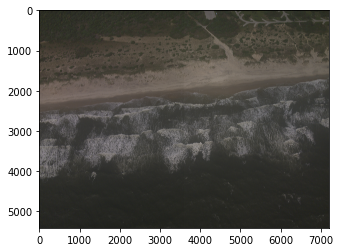

In [ ]:
plt.imshow(plt.imread(orig_img_list[cluster_index[3][4]]))

# Intracluster distances

In [14]:

from sklearn.metrics.pairwise import euclidean_distances

In [23]:
dists = euclidean_distances(kmodel.cluster_centers_)

In [16]:
import pandas as pd
pd.DataFrame(dists)



0            1            2  ...            6            7            8
0     0.000000  4579.389648  6137.511719  ...  5062.461426  5233.434082  5187.584961
1  4579.389648     0.000000  4802.256348  ...  5402.735840  3934.596436  5498.252441
2  6137.511719  4802.256348     0.000000  ...  5189.277832  4602.966309  5501.541992
3  5069.432617  5086.463379  5426.839844  ...  3284.804932  3320.395508  5598.861816
4  5499.004395  5008.788574  2747.531006  ...  3821.687744  5029.864258  3237.684570
5  4590.911621  2976.816162  2435.022949  ...  4276.208008  3534.417236  4488.781738
6  5062.461426  5402.735840  5189.277832  ...     0.000000  5028.754883  3502.981201
7  5233.434082  3934.596436  4602.966309  ...  5028.754883     0.000000  6258.725098
8  5187.584961  5498.252441  5501.541992  ...  3502.981201  6258.725098     0.000000

[9 rows x 9 columns]

# Intercluster distances

In [ ]:
from yellowbrick.cluster import InterclusterDistance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f90779d2240>,
                     embedding='mds', legend=True, legend_loc='lower left',
                     legend_size=1.5, max_size=25000, min_size=400, model=None,
                     random_state=728, scoring='membership')

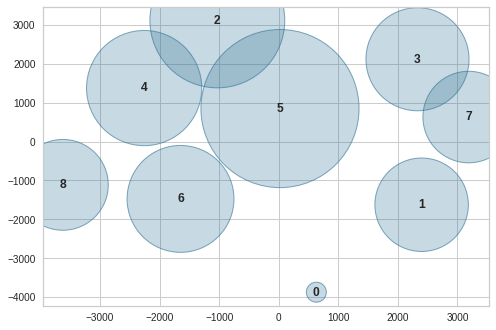

In [ ]:
k = 9
kmodel = KMeans(n_clusters = k, n_jobs=-1, random_state=728)

visualizer = InterclusterDistance(kmodel,random_state=728)

visualizer.fit(pred_images)        # Fit the data to the visualizer